# Import & Preprocess Data

In [7]:
import pandas as pd

training_link = "training.csv"
test_link = "test.csv"

# extract column
df_train = pd.read_csv(training_link).drop(columns="SK_ID_CURR")
df_test = pd.read_csv(test_link).drop(columns="SK_ID_CURR")

for (var, dtype) in zip(df_train.columns, df_train.dtypes):
    if dtype == "object":
        dummies = pd.get_dummies(df_train[var], prefix=var)
        df_train = df_train.drop(columns=var).merge(dummies,left_index=True,right_index=True)

df_train = df_train.fillna(df_train.mean())

target = "AMT_INCOME_TOTAL"
X = df_train.loc[:, df_train.columns != target]
y = df_train[target]

# Variance
Variance calculates the spread between numbers in a dataset. Small variance value for a feature variable indicates that the variable won't have any influence on the prediction since due to lack of spread.

For now, we want to remove variance score of 0 which column "FLAG_MOBIL" scored so we can remove that column for both tasks.

In [8]:
from sklearn.feature_selection import VarianceThreshold

df_var = df_train.var(numeric_only=True)
thres = 0

for (name, val) in sorted(list(zip(df_var.index, df_var.values)), key = lambda x:  x[1]):
    if val <= thres and name.isupper():
        print("{}: \t {:f}".format(name, val))
        df_train = df_train.drop(columns=name)

FLAG_MOBIL: 	 0.000000


# Covariance

Covariance calculates the direction of relationship between 2 variables. We aim to search for high covariance value between feature and target variable which indicates that when a feature is low/high, then the target value will be high/low.

Much like variance, we are only doing numerical variables and not categorical variables.

It's worth to note that all variables "FLAG_DOCUMENT_#" are low in covariance so we can remove it.

In [9]:
df_cov = abs(df_train.cov())[target]

for (val, num) in sorted(list(zip(df_cov.index, df_cov.values)), key = lambda x: x[1]):
    if val.isupper():
        print ("{:<40} {}".format(val, round(num,3)))
        
doc_list = ["FLAG_DOCUMENT_{}".format(x) for x in range(2, 22)]
df_train = df_train.drop(columns=doc_list)

FLAG_DOCUMENT_10                         0.21
FLAG_DOCUMENT_12                         0.521
FLAG_DOCUMENT_21                         0.711
CODE_GENDER_XNA                          1.084
FLAG_DOCUMENT_2                          2.331
FLAG_DOCUMENT_17                         2.703
FLAG_DOCUMENT_20                         5.262
LANDAREA_AVG                             5.982
FLAG_DOCUMENT_4                          6.029
LANDAREA_MEDI                            8.284
FLAG_DOCUMENT_19                         11.139
FLAG_DOCUMENT_5                          13.502
REG_CITY_NOT_LIVE_CITY                   16.964
FLAG_DOCUMENT_7                          18.698
LANDAREA_MODE                            28.229
AMT_REQ_CREDIT_BUREAU_HOUR               28.827
FLAG_DOCUMENT_11                         31.671
AMT_REQ_CREDIT_BUREAU_WEEK               34.213
NONLIVINGAPARTMENTS_MODE                 45.975
NONLIVINGAPARTMENTS_MEDI                 51.437
YEARS_BEGINEXPLUATATION_AVG              52.959
NON

# Correlation
Correlation referes to how much 2 variables have a linear relationship with each other. Think of it as a scaled version of covariance as the value ranges from -1 to 1.

We want to remove feature variables that have correlation value with target variable near 0 which indicates that there is absolute no relation between the feature and target value.

In [10]:
df_corr = abs(df_train.corr())[target]
corr_threshold = 0.01
corr_lst = []

for (val, num) in sorted(list(zip(df_corr.index, df_corr.values)), key = lambda x: x[1]):
    if val.isupper() and num <= corr_threshold:
        print ("{:<40} {}".format(val, round(num,6)))
        corr_lst.append(val)
        
df_train = df_train.drop(columns=corr_lst)

REG_CITY_NOT_LIVE_CITY                   0.000164
LANDAREA_AVG                             0.000311
LANDAREA_MEDI                            0.000427
AMT_REQ_CREDIT_BUREAU_WEEK               0.000477
CODE_GENDER_XNA                          0.000674
FLAG_PHONE                               0.000732
WEEKDAY_APPR_PROCESS_START_FRIDAY        0.000841
AMT_REQ_CREDIT_BUREAU_HOUR               0.000981
WEEKDAY_APPR_PROCESS_START_THURSDAY      0.001072
TARGET                                   0.001077
WEEKDAY_APPR_PROCESS_START_MONDAY        0.001212
LANDAREA_MODE                            0.001454
WEEKDAY_APPR_PROCESS_START_SATURDAY      0.001763
WEEKDAY_APPR_PROCESS_START_WEDNESDAY     0.002166
WEEKDAY_APPR_PROCESS_START_SUNDAY        0.002303
REG_CITY_NOT_WORK_CITY                   0.002387
ENTRANCES_MODE                           0.002592
DAYS_ID_PUBLISH                          0.002779
AMT_REQ_CREDIT_BUREAU_QRT                0.002826
YEARS_BEGINEXPLUATATION_MODE             0.003267


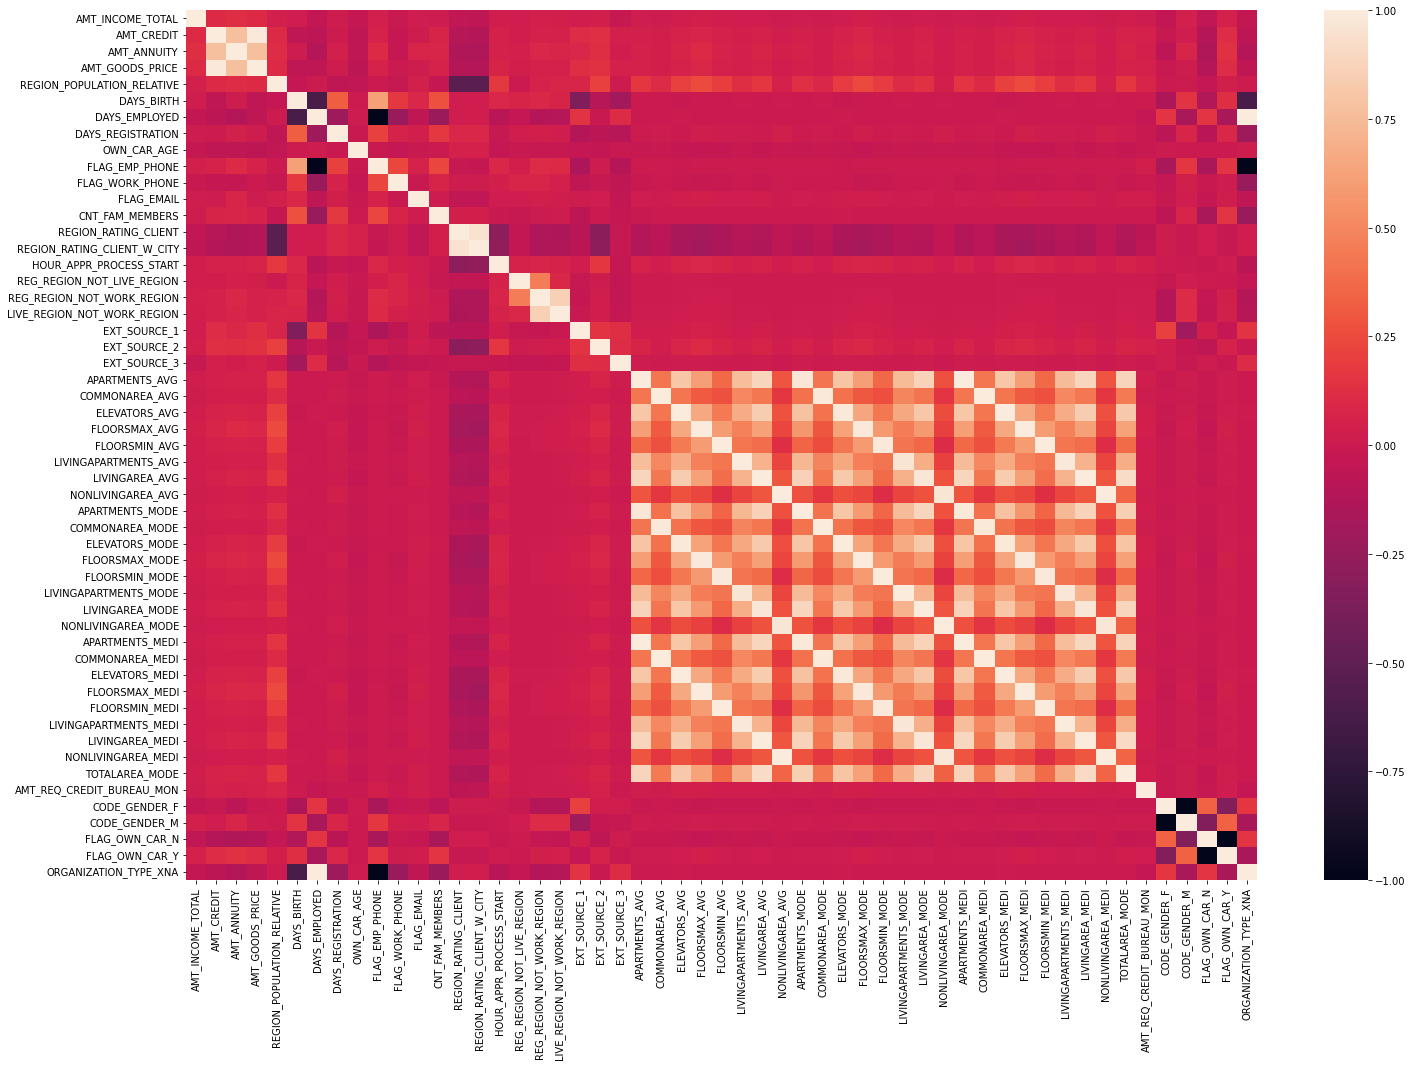

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt

col_lst = []
for col in df_train.columns:
    if col.isupper():
        col_lst.append(col)
    

fig_dims = (24, 16)
fig, ax = plt.subplots(figsize=fig_dims)
sn.heatmap(df_train[col_lst].corr(), ax=ax)
plt.show()

# P-value
Determine if a variable's change is meaningful to the target variable by checking the null hypothesis. The lower the value is, the better

In [110]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       AMT_INCOME_TOTAL   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.86
Date:                Tue, 19 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:42:12   Log-Likelihood:            -1.5377e+06
No. Observations:              108000   AIC:                         3.076e+06
Df Residuals:                  107767   BIC:                         3.078e+06
Df Model:                         232                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------